## Climate indicator comparisons

In [1]:
# %matplotlib qt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore, pearsonr
# OUTPATH = './output'
IOPATH = '/ocean/rbeutel/MOAD/analysis-becca/Synthesis/data/CCS_obs.csv'

In [2]:
obs = pd.read_csv(IOPATH)
obs

,Unnamed: 0.1,Unnamed: 0,time,longitude (degrees_east),latitude (degrees_north),depth (m),pressure (dbar),temperature (degC),salinity (g kg-1),DO (umol kg-1),...,Zn (nmol kg-1),source,Nstar (umol kg-1),spice,density (kg m-3),current,location,[TA-DIC] (uM),NSdist,EWdist
0,0,0,1933-07-25 00:00:00+00:00,-126.76,49.34,1.0,1.008587,NaN,32.070847,NaN,...,NaN,ios bottle,NaN,NaN,NaN,shelf,shelf,NaN,0.000000,-0.0
1,1,1,1933-07-25 00:00:00+00:00,-126.76,49.34,2.0,2.017180,NaN,32.090943,NaN,...,NaN,ios bottle,NaN,NaN,NaN,shelf,shelf,NaN,0.000000,-0.0
2,2,2,1933-07-25 00:00:00+00:00,-126.76,49.34,4.0,4.034378,NaN,32.090906,NaN,...,NaN,ios bottle,NaN,NaN,NaN,shelf,shelf,NaN,0.000000,-0.0
3,3,3,1933-07-25 00:00:00+00:00,-126.76,49.34,6.0,6.051598,NaN,32.090870,NaN,...,NaN,ios bottle,NaN,NaN,NaN,shelf,shelf,NaN,0.000000,-0.0
4,4,4,1933-07-25 00:00:00+00:00,-126.76,49.34,10.0,10.086095,NaN,32.181305,NaN,...,NaN,ios bottle,NaN,NaN,NaN,shelf,shelf,NaN,0.000000,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378648,1378648,1402109,2024-11-18 00:00:00+00:00,-124.95,44.38,0.0,0.000000,12.713836,32.386146,312.025459,...,NaN,ooi,NaN,-0.251376,1024.310436,NaN,slope,NaN,484.541716,NaN
1378649,1378649,1402110,2024-11-18 00:00:00+00:00,-124.94,44.36,0.0,0.000000,12.712860,32.386131,NaN,...,NaN,ooi,NaN,-0.251582,1024.310612,NaN,slope,NaN,484.541716,NaN
1378650,1378650,1402111,2024-11-18 00:00:00+00:00,-124.57,46.99,0.0,0.000000,10.586080,32.728763,202.661375,...,NaN,ooi,NaN,-0.405998,1024.962794,shelf,shelf,NaN,215.824564,-0.0
1378651,1378651,1402112,2024-11-18 00:00:00+00:00,-124.56,46.99,0.0,0.000000,12.215222,32.245641,308.384776,...,NaN,ooi,NaN,-0.452611,1024.296731,shelf,shelf,NaN,215.824564,-0.0


In [3]:
pd.unique(obs['current'])

array(['shelf', nan, 'CC', 'CUC'], dtype=object)

In [4]:
# add year and month column
obs['time'] = pd.to_datetime(obs['time'])

obs['year'] = obs.time.dt.year
obs['months'] = obs.time.dt.month

In [5]:
# Setting up different currents
obs_shelf = obs[obs['current'] == 'shelf']
obs_cuc = obs[obs['current'] == 'CUC']
obs_cc = obs[obs['current'] == 'CC']

In [6]:
# make a 'dist' column of the distances we're actually going to use for each current
# for shelf and cuc its simply the NS dist

obs_cuc['dist'] = obs_cuc.NSdist
obs_shelf['dist'] = obs_shelf.NSdist

# for the CC its a bit more complicated
# first, just pick whatever line the point is closer to
abs_a = obs_cc.NSdist.abs()
abs_b = obs_cc.EWdist.abs()

obs_cc['dist'] = np.select(
    [
        abs_a < abs_b,       # a closer to zero
        abs_b < abs_a,       # b closer to zero
        abs_a.isna(),        # a NaN, take b
        abs_b.isna()         # b NaN, take a
    ],
    [
        obs_cc.NSdist,
        obs_cc.EWdist,
        obs_cc.EWdist,
        obs_cc.NSdist
    ],
    default=np.nan
)

# and then also default that anywhere that the NS dist is -ve, the EW distance should be taken
obs_cc.dist[obs_cc.NSdist < 0] = obs_cc.EWdist

/tmp/ipykernel_647005/497193821.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_cuc['dist'] = obs_cuc.NSdist
/tmp/ipykernel_647005/497193821.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_shelf['dist'] = obs_shelf.NSdist
/tmp/ipykernel_647005/497193821.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

### Where I got climate indicators from:

Originally from my research with Rich which can be found in /ocean/ghoeven/Atlas/Climatology2024

enso.csv 
https://psl.noaa.gov/enso/mei/

npgo.csv 
http://www.o3d.org/npgo/

pdo.csv
https://www.ncei.noaa.gov/access/monitoring/pdo/

In [7]:
# Loading in Climate Indicators

# ENSO
enso = pd.read_csv('/ocean/rbeutel/MOAD/analysis-becca/Synthesis/data/enso1979.csv', names=['year']+[str(x+1) for x in range(12)])

enso = enso.melt(id_vars='year', var_name='months', value_name='index') # rearange df into 3x552 instead of 13x46
enso['months'] = enso['months'].astype(int) 
enso = enso.sort_values(['year', 'months']).reset_index(drop=True)

enso['day'] = 1 
enso['time'] = pd.to_datetime(enso[['year', 'months', 'day']])

start_of_year = pd.to_datetime(enso['year'].astype(str) + "-01-01")
end_of_year = pd.to_datetime((enso['year'] + 1).astype(str) + "-01-01")
enso['decimal_yr'] = enso['year'] + (
    (enso['time'] - start_of_year) / 
    (end_of_year - start_of_year)
)

# NPGO
npgo = pd.read_csv('/ocean/rbeutel/MOAD/analysis-becca/Synthesis/data/npgo1950.csv', names=['year', 'months', 'index'])

npgo['day'] = 1 
npgo['time'] = pd.to_datetime(npgo[['year', 'months', 'day']])

start_of_year = pd.to_datetime(npgo['year'].astype(str) + "-01-01")
end_of_year = pd.to_datetime((npgo['year'] + 1).astype(str) + "-01-01")
npgo['decimal_yr'] = npgo['year'] + (
    (npgo['time'] - start_of_year) / 
    (end_of_year - start_of_year)
)

# PDO
pdo = pd.read_csv('/ocean/rbeutel/MOAD/analysis-becca/Synthesis/data/pdo1854.csv', names=['year']+[str(x+1) for x in range(12)])

pdo = pdo.melt(id_vars='year', var_name='months', value_name='index')
pdo['months'] = pdo['months'].astype(int)
pdo = pdo.sort_values(['year', 'months']).reset_index(drop=True)

pdo['day'] = 1 
pdo['time'] = pd.to_datetime(pdo[['year', 'months', 'day']])

start_of_year = pd.to_datetime(pdo['year'].astype(str) + "-01-01")
end_of_year = pd.to_datetime((pdo['year'] + 1).astype(str) + "-01-01")
pdo['decimal_yr'] = pdo['year'] + (
    (pdo['time'] - start_of_year) / 
    (end_of_year - start_of_year)
)


## Functions

In [22]:
# ---------- helpers ----------
def _ensure_numeric(df, cols):
    out = df.copy()
    for c in cols:
        out[c] = pd.to_numeric(out[c], errors="coerce")
    return out

def _bin_depth(depth_series, depth_edges):
    return pd.cut(depth_series, bins=depth_edges, right=False,
                  include_lowest=True, labels=False)

# ---------- statistics ----------
def _calc_stats(mean_anom, df2, t_month, lag_months=0):
    # 1. Make both series pandas Series with decimal-year index
    df2_series = pd.Series(df2['index'].values, index=df2['decimal_yr'])
    # shift anom series forward by lag months while you do so
    anom_series = pd.Series(mean_anom, index=t_month)
    anom_shifted_index = anom_series.index + (lag_months / 12.0)
    anom_series = pd.Series(anom_series.values, index=anom_shifted_index)

    # 2. Reindex to match the anomaly time base
    df2_aligned = df2_series.reindex(anom_series.index, method='nearest', tolerance=1/52)
    # tolerance=1/52 ~ ±1 weeks in decimal-year units

    # 3. Drop NaNs (if df2 doesn't cover full range)
    mask = ~df2_aligned.isna() & ~anom_series.isna()
    df2_matched = df2_aligned[mask].values
    anom_matched = anom_series[mask].values

    stats = {}
    stats['r'] = pearsonr(anom_matched,df2_matched).statistic
    stats['pvalue'] = pearsonr(anom_matched,df2_matched).pvalue
    stats['n'] = int(mask.sum())
    
    return stats

def _find_best_lag(mean_anom, t_month, df2, max_lag_months=24):
    """
    Scan forward lags k = 0..max_lag_months (months) and return the lag with max |r|.

    Returns
    -------
    best : dict
        {'best_lag_months','r','pvalue','n','r_by_lag','p_by_lag'}
    """
    r_by_lag = []
    p_by_lag = []
    n_by_lag = []

    for k in range(int(max_lag_months) + 1):
        stats = _calc_stats(mean_anom, df2, t_month, lag_months=k)
        r_by_lag.append(stats['r'])
        p_by_lag.append(stats['pvalue'])
        n_by_lag.append(stats['n'])

    r_arr = np.asarray(r_by_lag, float)
    # choose by maximum absolute correlation; if you prefer positive only, drop abs()
    if np.all(np.isnan(r_arr)):
        return {'best_lag_months': np.nan, 'r': np.nan, 'pvalue': np.nan, 'n': 0}

    kbest = int(np.nanargmax(np.abs(r_arr)))
    return {'best_lag_months': kbest, 'r': r_arr[kbest], 'pvalue': p_by_lag[kbest], 'n': n_by_lag[kbest]}

def plot_panel(ax, mean_anom, df2, t_month, max_lag_months=24,colour='k',xloc=0,yloc=0.82):
    best = _find_best_lag(mean_anom, t_month, df2, max_lag_months=max_lag_months)

    statstext = (f"Lag = {best['best_lag_months']} mo\n"
                 f"Pearson r = {best['r']:.2f}  (p = {best['pvalue']:.3f})")

    props = dict(boxstyle='round', facecolor='w',edgecolor=colour, alpha=0.7)
    c = ax.text(xloc, yloc, statstext, bbox=props, transform=ax.transAxes, fontsize=9)
    return c

# ---------- monthly depth-binned means ----------
def avg_profile_12months_depth(obs_used, depth_edges, variable_str, return_counts=False):
    s = _ensure_numeric(obs_used, [variable_str, 'depth (m)', 'months'])
    s = s.dropna(subset=[variable_str, 'depth (m)', 'months']).copy()
    s['_month'] = s['months'].astype(int)
    s['_zbin'] = _bin_depth(s['depth (m)'], depth_edges)

    g = s.groupby(['_month', '_zbin'])[variable_str].agg(['mean', 'count'])
    nbins = len(depth_edges) - 1
    mean_arr = np.full((12, nbins), np.nan)
    cnt_arr = np.zeros((12, nbins), dtype=int)

    if not g.empty:
        idx = g.index.to_frame(index=False)
        m_ix = idx['_month'].to_numpy() - 1
        z_ix = idx['_zbin'].astype(int).to_numpy()
        mean_arr[m_ix, z_ix] = g['mean'].to_numpy()
        cnt_arr[m_ix, z_ix] = g['count'].to_numpy()

    return (mean_arr, cnt_arr) if return_counts else mean_arr

def contour_prep_depth_monthly(obs_used, start_yr, end_yr, depth_edges,
                               variable_str, base_period=None, min_samples_per_cell=3):
    years = np.arange(int(start_yr), int(end_yr) + 1)
    nyears = len(years)
    nbins = len(depth_edges) - 1

    # climatology base period
    if base_period is not None:
        by0, by1 = base_period
        clim_obs = obs_used[(obs_used['year'] >= by0) & (obs_used['year'] <= by1)]
    else:
        clim_obs = obs_used

    clim_mean, clim_cnt = avg_profile_12months_depth(clim_obs, depth_edges,
                                                     variable_str, return_counts=True)

    yr_month_means = []
    yr_month_counts = []
    for yr in years:
        m12, c12 = avg_profile_12months_depth(
            obs_used[obs_used['year'] == yr], depth_edges, variable_str, return_counts=True)
        yr_month_means.append(m12)
        yr_month_counts.append(c12)

    yr_means = np.vstack(yr_month_means)
    yr_counts = np.vstack(yr_month_counts)
    clim_tiled = np.tile(clim_mean, (nyears, 1))

    anom = (yr_means - clim_tiled).T
    mask = (yr_counts.T >= min_samples_per_cell)
    anom[~mask] = np.nan

    months = np.tile(np.arange(1, 13), nyears)
    years_rep = np.repeat(years, 12)
    t_month = years_rep + (months - 1) / 12.0 # t_month at start of month to align with dates we set for climate indices
    return anom, t_month

# ---------- monthly lat-binned means ----------
def avg_profile_12months_dist(obs_used, dist_edges, variable_str, return_counts=False):
    s = _ensure_numeric(obs_used, [variable_str, 'dist', 'months'])
    s = s.dropna(subset=[variable_str, 'dist', 'months']).copy()
    s['_month'] = s['months'].astype(int)
    s['_zbin'] = _bin_depth(s['dist'], dist_edges)

    g = s.groupby(['_month', '_zbin'])[variable_str].agg(['mean', 'count'])
    nbins = len(dist_edges) - 1
    mean_arr = np.full((12, nbins), np.nan)
    cnt_arr = np.zeros((12, nbins), dtype=int)

    if not g.empty:
        idx = g.index.to_frame(index=False)
        m_ix = idx['_month'].to_numpy() - 1
        z_ix = idx['_zbin'].astype(int).to_numpy()
        mean_arr[m_ix, z_ix] = g['mean'].to_numpy()
        cnt_arr[m_ix, z_ix] = g['count'].to_numpy()

    return (mean_arr, cnt_arr) if return_counts else mean_arr

def contour_prep_dist_monthly(obs_used, start_yr, end_yr, dist_edges,
                               variable_str, base_period=None, min_samples_per_cell=3):
    years = np.arange(int(start_yr), int(end_yr) + 1)
    nyears = len(years)
    nbins = len(dist_edges) - 1

    # climatology base period
    if base_period is not None:
        by0, by1 = base_period
        clim_obs = obs_used[(obs_used['year'] >= by0) & (obs_used['year'] <= by1)]
    else:
        clim_obs = obs_used

    clim_mean, clim_cnt = avg_profile_12months_dist(clim_obs, dist_edges,
                                                     variable_str, return_counts=True)

    yr_month_means = []
    yr_month_counts = []
    for yr in years:
        m12, c12 = avg_profile_12months_dist(
            obs_used[obs_used['year'] == yr], dist_edges, variable_str, return_counts=True)
        yr_month_means.append(m12)
        yr_month_counts.append(c12)

    yr_means = np.vstack(yr_month_means)
    yr_counts = np.vstack(yr_month_counts)
    clim_tiled = np.tile(clim_mean, (nyears, 1))

    anom = (yr_means - clim_tiled).T
    mask = (yr_counts.T >= min_samples_per_cell)
    anom[~mask] = np.nan

    months = np.tile(np.arange(1, 13), nyears)
    years_rep = np.repeat(years, 12)
    t_month = years_rep + (months - 1) / 12.0 # t_month at start of month to align with dates we set for climate indices
    return anom, t_month


## Temperature Depth Anomaly

/tmp/ipykernel_647005/3553134363.py:18: RuntimeWarning: Mean of empty slice
  mean_anom = np.nanmean(anom_array, axis=0) # taking the mean of the depth binned anomaly (reduces depth sampling bias where possible)


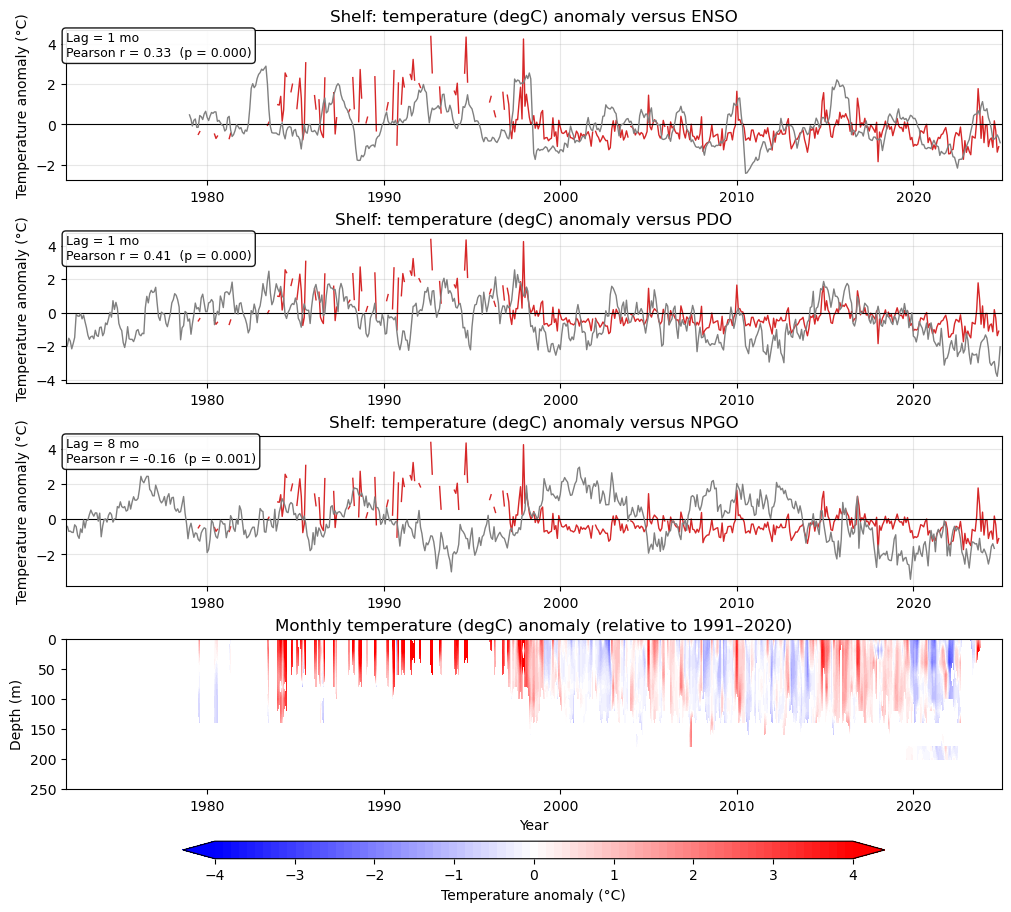

In [9]:
obs_used = obs_shelf.copy()
variable_str = 'temperature (degC)'
start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[variable_str])]))
end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[variable_str])]))
max_depth = np.nanmax(obs_used['depth (m)'][~np.isnan(obs_used[variable_str])])
depth_edges = np.arange(0, np.ceil(max_depth / 20) * 20 + 20, 20)
base_period = (1991, 2020)

anom_array, t_month = contour_prep_depth_monthly(
    obs_used, start_yr, end_yr, depth_edges,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

# ---------- plot ----------
fig, ax = plt.subplots(4, 1, figsize=(10, 9), constrained_layout=True)

# --- top 3 pannels: mean anomaly over all depths compared to ENSO, PDO, NPGO---
mean_anom = np.nanmean(anom_array, axis=0) # taking the mean of the depth binned anomaly (reduces depth sampling bias where possible)
indices_name = ['ENSO','PDO','NPGO']
for i in range(3):
    ax[i].plot(t_month, zscore(mean_anom, nan_policy='omit'), color='tab:red', lw=1, label='Mean anomaly') # zscore converts the anom to a -1-1 variation based on std above and below mean
    ax[i].axhline(0, color='k', lw=0.8)
    ax[i].grid(True, alpha=0.3)
    ax[i].set_xlim(start_yr, end_yr + 1)
    ax[i].set_ylabel('Temperature anomaly (°C)')
    ax[i].set_title(f"Shelf: {variable_str} anomaly versus {indices_name[i]}")

    if i ==0:
        Yind = enso['index']
        Xind = enso['decimal_yr']
        plot_panel(ax[i], mean_anom, enso,t_month)
    elif i ==1:
        Yind = pdo['index']
        Xind = pdo['decimal_yr']
        plot_panel(ax[i], mean_anom, pdo,t_month)
    elif i==2:
        Yind = npgo['index']
        Xind = npgo['decimal_yr']
        plot_panel(ax[i], mean_anom, npgo,t_month)
    ax[i].plot(Xind, Yind, color='gray', lw=1, label=indices_name[i])
# ax[0].legend()

# --- bottom panel: depth–time contour ---
X, Y = np.meshgrid(t_month, depth_edges[:-1])
vmax = 4
levels = np.linspace(-vmax, vmax, 80)
cp = ax[3].contourf(X, Y, anom_array, levels=levels, cmap='bwr', extend='both')
ax[3].invert_yaxis()
ax[3].set_ylim(250, 0)
ax[3].set_xlim(start_yr, end_yr + 1)
ax[3].set_xlabel('Year')
ax[3].set_ylabel('Depth (m)')
ax[3].set_title(f"Monthly {variable_str} anomaly (relative to {base_period[0]}–{base_period[1]})")

cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.01,
                    aspect=40, shrink=0.75, ticks=np.arange(-vmax, vmax+1))
cbar.set_label('Temperature anomaly (°C)')


/tmp/ipykernel_647005/2970337813.py:18: RuntimeWarning: Mean of empty slice
  mean_anom = np.nanmean(anom_array, axis=0) # taking the mean of the depth binned anomaly (reduces depth sampling bias where possible)


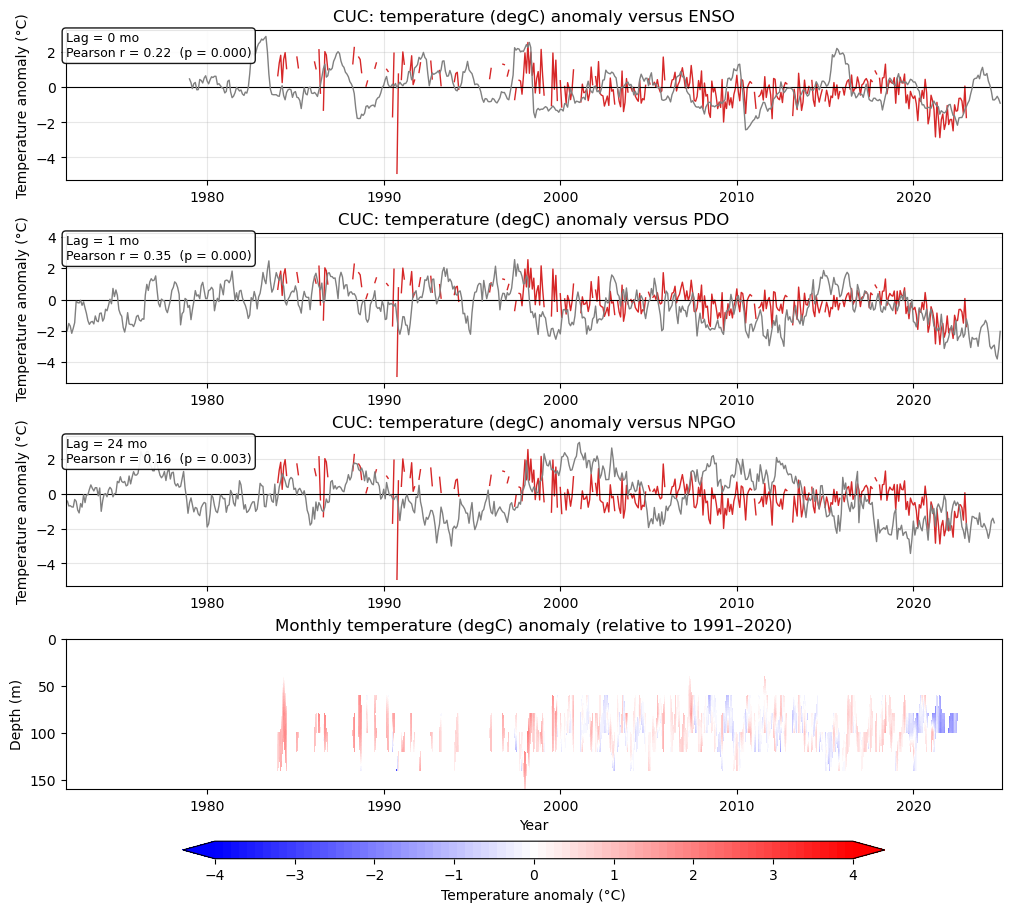

In [10]:
obs_used = obs_cuc.copy()
variable_str = 'temperature (degC)'
start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[variable_str])]))
end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[variable_str])]))
max_depth = np.nanmax(obs_used['depth (m)'][~np.isnan(obs_used[variable_str])])
depth_edges = np.arange(0, np.ceil(max_depth / 20) * 20 + 20, 20)
base_period = (1991, 2020)

anom_array, t_month = contour_prep_depth_monthly(
    obs_used, start_yr, end_yr, depth_edges,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

# ---------- plot ----------
fig, ax = plt.subplots(4, 1, figsize=(10, 9), constrained_layout=True)

# --- top 3 pannels: mean anomaly over all depths compared to ENSO, PDO, NPGO---
mean_anom = np.nanmean(anom_array, axis=0) # taking the mean of the depth binned anomaly (reduces depth sampling bias where possible)
indices_name = ['ENSO','PDO','NPGO']
for i in range(3):
    ax[i].plot(t_month, zscore(mean_anom, nan_policy='omit'), color='tab:red', lw=1, label='Mean anomaly') # zscore converts the anom to a -1-1 variation based on std above and below mean
    ax[i].axhline(0, color='k', lw=0.8)
    ax[i].grid(True, alpha=0.3)
    ax[i].set_xlim(start_yr, end_yr + 1)
    ax[i].set_ylabel('Temperature anomaly (°C)')
    ax[i].set_title(f"CUC: {variable_str} anomaly versus {indices_name[i]}")

    if i ==0:
        Yind = enso['index']
        Xind = enso['decimal_yr']
        plot_panel(ax[i], mean_anom, enso,t_month)
    elif i ==1:
        Yind = pdo['index']
        Xind = pdo['decimal_yr']
        plot_panel(ax[i], mean_anom, pdo,t_month)
    elif i==2:
        Yind = npgo['index']
        Xind = npgo['decimal_yr']
        plot_panel(ax[i], mean_anom, npgo,t_month)
    ax[i].plot(Xind, Yind, color='gray', lw=1, label=indices_name[i])
# ax[0].legend()

# --- bottom panel: depth–time contour ---
X, Y = np.meshgrid(t_month, depth_edges[:-1])
vmax = 4
levels = np.linspace(-vmax, vmax, 80)
cp = ax[3].contourf(X, Y, anom_array, levels=levels, cmap='bwr', extend='both')
ax[3].invert_yaxis()
# ax[3].set_ylim(250, 0)
ax[3].set_xlim(start_yr, end_yr + 1)
ax[3].set_xlabel('Year')
ax[3].set_ylabel('Depth (m)')
ax[3].set_title(f"Monthly {variable_str} anomaly (relative to {base_period[0]}–{base_period[1]})")

cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.01,
                    aspect=40, shrink=0.75, ticks=np.arange(-vmax, vmax+1))
cbar.set_label('Temperature anomaly (°C)')


/tmp/ipykernel_647005/1238657310.py:18: RuntimeWarning: Mean of empty slice
  mean_anom = np.nanmean(anom_array, axis=0) # taking the mean of the depth binned anomaly (reduces depth sampling bias where possible)


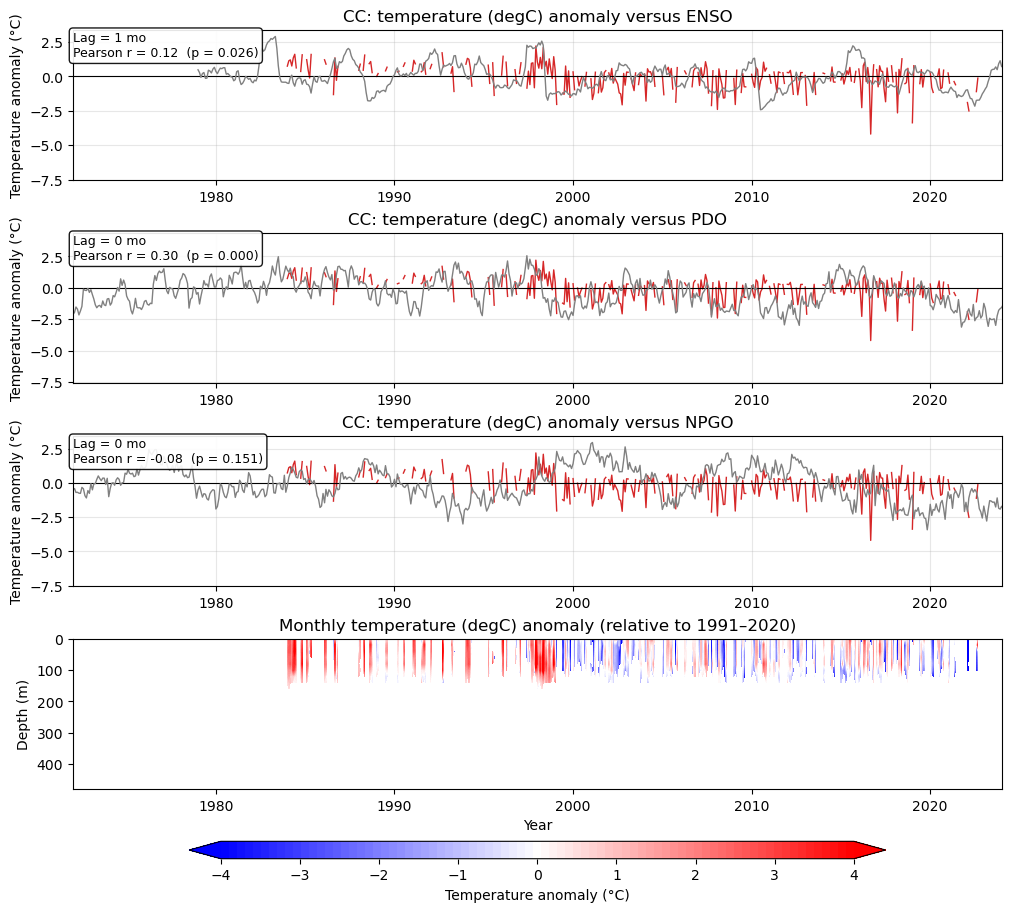

In [11]:
obs_used = obs_cc.copy()
variable_str = 'temperature (degC)'
start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[variable_str])]))
end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[variable_str])]))
max_depth = np.nanmax(obs_used['depth (m)'][~np.isnan(obs_used[variable_str])])
depth_edges = np.arange(0, np.ceil(max_depth / 20) * 20 + 20, 20)
base_period = (1991, 2020)

anom_array, t_month = contour_prep_depth_monthly(
    obs_used, start_yr, end_yr, depth_edges,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

# ---------- plot ----------
fig, ax = plt.subplots(4, 1, figsize=(10, 9), constrained_layout=True)

# --- top 3 pannels: mean anomaly over all depths compared to ENSO, PDO, NPGO---
mean_anom = np.nanmean(anom_array, axis=0) # taking the mean of the depth binned anomaly (reduces depth sampling bias where possible)
indices_name = ['ENSO','PDO','NPGO']
for i in range(3):
    ax[i].plot(t_month, zscore(mean_anom, nan_policy='omit'), color='tab:red', lw=1, label='Mean anomaly') # zscore converts the anom to a -1-1 variation based on std above and below mean
    ax[i].axhline(0, color='k', lw=0.8)
    ax[i].grid(True, alpha=0.3)
    ax[i].set_xlim(start_yr, end_yr + 1)
    ax[i].set_ylabel('Temperature anomaly (°C)')
    ax[i].set_title(f"CC: {variable_str} anomaly versus {indices_name[i]}")

    if i ==0:
        Yind = enso['index']
        Xind = enso['decimal_yr']
        plot_panel(ax[i], mean_anom, enso,t_month)
    elif i ==1:
        Yind = pdo['index']
        Xind = pdo['decimal_yr']
        plot_panel(ax[i], mean_anom, pdo,t_month)
    elif i==2:
        Yind = npgo['index']
        Xind = npgo['decimal_yr']
        plot_panel(ax[i], mean_anom, npgo,t_month)
    ax[i].plot(Xind, Yind, color='gray', lw=1, label=indices_name[i])
# ax[0].legend()

# --- bottom panel: depth–time contour ---
X, Y = np.meshgrid(t_month, depth_edges[:-1])
vmax = 4
levels = np.linspace(-vmax, vmax, 80)
cp = ax[3].contourf(X, Y, anom_array, levels=levels, cmap='bwr', extend='both')
ax[3].invert_yaxis()
# ax[3].set_ylim(250, 0)
ax[3].set_xlim(start_yr, end_yr + 1)
ax[3].set_xlabel('Year')
ax[3].set_ylabel('Depth (m)')
ax[3].set_title(f"Monthly {variable_str} anomaly (relative to {base_period[0]}–{base_period[1]})")

cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.01,
                    aspect=40, shrink=0.75, ticks=np.arange(-vmax, vmax+1))
cbar.set_label('Temperature anomaly (°C)')


## Salinity Depth Anomaly Plots

/tmp/ipykernel_647005/2279440622.py:18: RuntimeWarning: Mean of empty slice
  mean_anom = np.nanmean(anom_array, axis=0) # taking the mean of the depth binned anomaly (reduces depth sampling bias where possible)


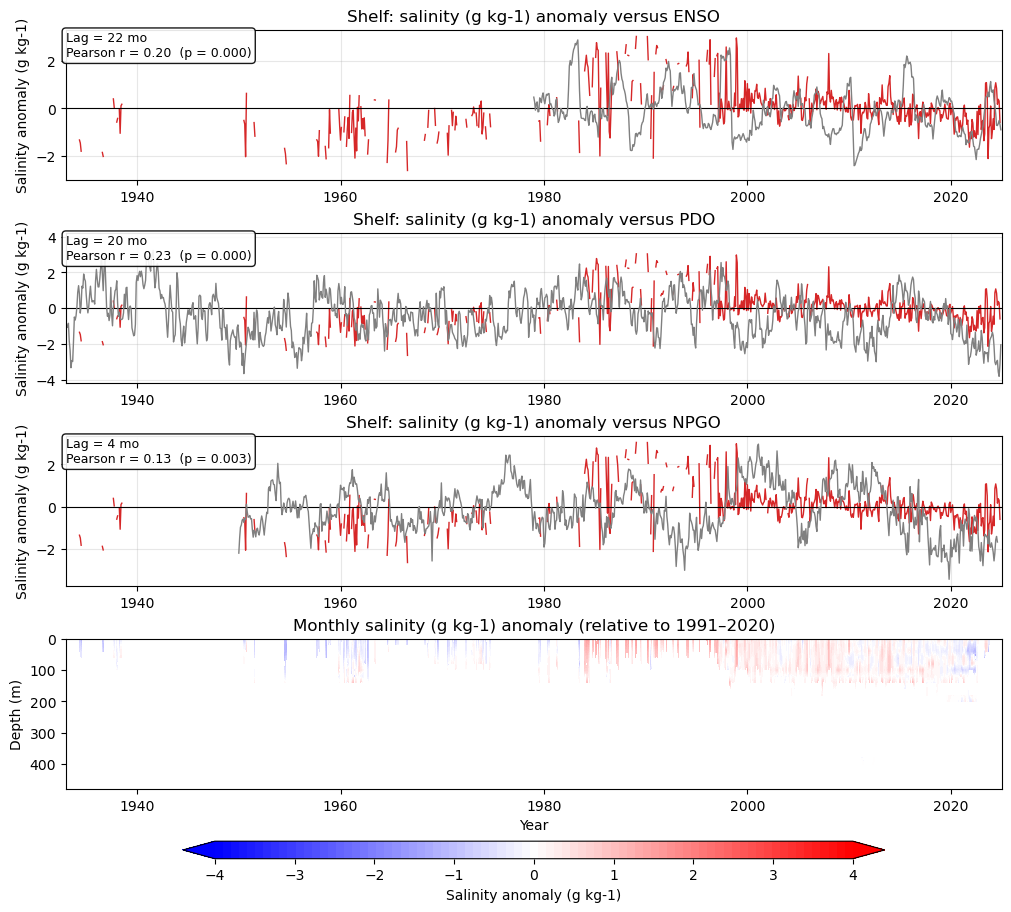

In [12]:
obs_used = obs_shelf.copy()
variable_str = 'salinity (g kg-1)'
start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[variable_str])]))
end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[variable_str])]))
max_depth = np.nanmax(obs_used['depth (m)'][~np.isnan(obs_used[variable_str])])
depth_edges = np.arange(0, np.ceil(max_depth / 20) * 20 + 20, 20)
base_period = (1991, 2020)

anom_array, t_month = contour_prep_depth_monthly(
    obs_used, start_yr, end_yr, depth_edges,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

# ---------- plot ----------
fig, ax = plt.subplots(4, 1, figsize=(10, 9), constrained_layout=True)

# --- top 3 pannels: mean anomaly over all depths compared to ENSO, PDO, NPGO---
mean_anom = np.nanmean(anom_array, axis=0) # taking the mean of the depth binned anomaly (reduces depth sampling bias where possible)
indices_name = ['ENSO','PDO','NPGO']
for i in range(3):
    ax[i].plot(t_month, zscore(mean_anom, nan_policy='omit'), color='tab:red', lw=1, label='Mean anomaly') # zscore converts the anom to a -1-1 variation based on std above and below mean
    ax[i].axhline(0, color='k', lw=0.8)
    ax[i].grid(True, alpha=0.3)
    ax[i].set_xlim(start_yr, end_yr + 1)
    ax[i].set_ylabel('Salinity anomaly (g kg-1)')
    ax[i].set_title(f"Shelf: {variable_str} anomaly versus {indices_name[i]}")

    if i ==0:
        Yind = enso['index']
        Xind = enso['decimal_yr']
        plot_panel(ax[i], mean_anom, enso,t_month)
    elif i ==1:
        Yind = pdo['index']
        Xind = pdo['decimal_yr']
        plot_panel(ax[i], mean_anom, pdo,t_month)
    elif i==2:
        Yind = npgo['index']
        Xind = npgo['decimal_yr']
        plot_panel(ax[i], mean_anom, npgo,t_month)
    ax[i].plot(Xind, Yind, color='gray', lw=1, label=indices_name[i])
# ax[0].legend()

# --- bottom panel: depth–time contour ---
X, Y = np.meshgrid(t_month, depth_edges[:-1])
vmax = 4
levels = np.linspace(-vmax, vmax, 80)
cp = ax[3].contourf(X, Y, anom_array, levels=levels, cmap='bwr', extend='both')
ax[3].invert_yaxis()
# ax[3].set_ylim(250, 0)
ax[3].set_xlim(start_yr, end_yr + 1)
ax[3].set_xlabel('Year')
ax[3].set_ylabel('Depth (m)')
ax[3].set_title(f"Monthly {variable_str} anomaly (relative to {base_period[0]}–{base_period[1]})")

cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.01,
                    aspect=40, shrink=0.75, ticks=np.arange(-vmax, vmax+1))
cbar.set_label('Salinity anomaly (g kg-1)')


/tmp/ipykernel_647005/1087488303.py:18: RuntimeWarning: Mean of empty slice
  mean_anom = np.nanmean(anom_array, axis=0) # taking the mean of the depth binned anomaly (reduces depth sampling bias where possible)


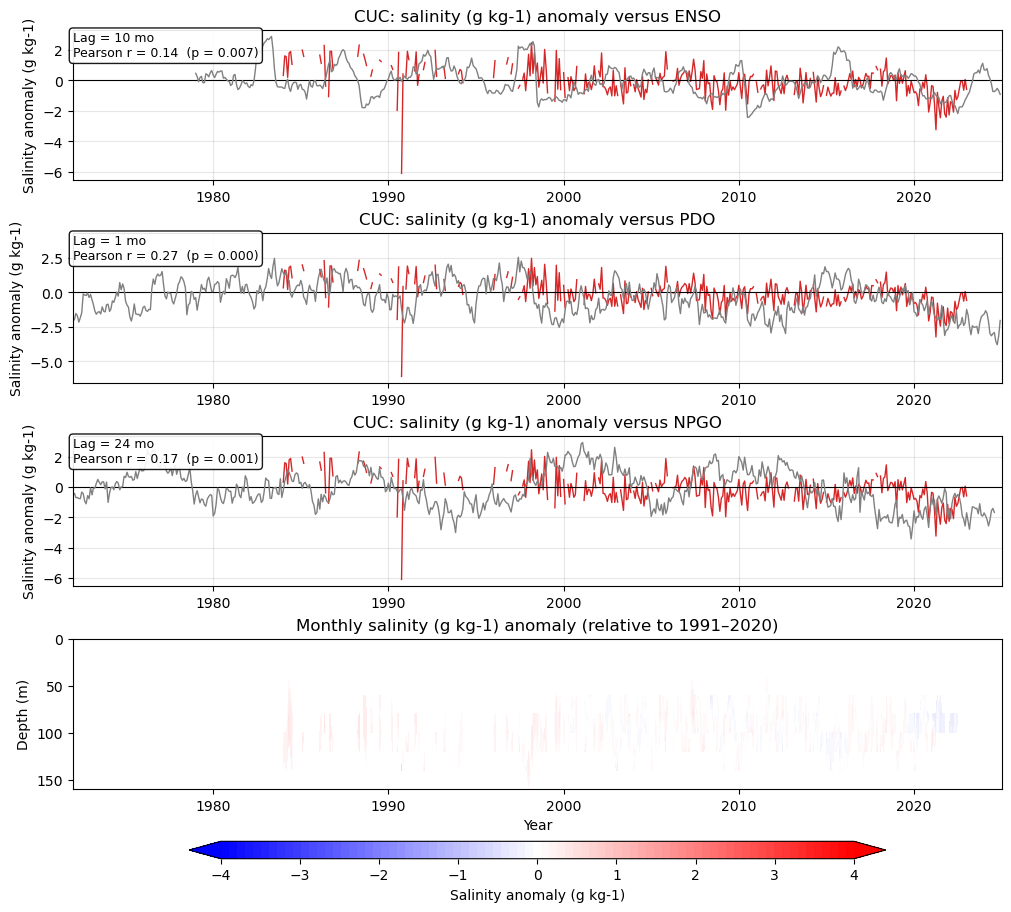

In [13]:
obs_used = obs_cuc.copy()
variable_str = 'salinity (g kg-1)'
start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[variable_str])]))
end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[variable_str])]))
max_depth = np.nanmax(obs_used['depth (m)'][~np.isnan(obs_used[variable_str])])
depth_edges = np.arange(0, np.ceil(max_depth / 20) * 20 + 20, 20)
base_period = (1991, 2020)

anom_array, t_month = contour_prep_depth_monthly(
    obs_used, start_yr, end_yr, depth_edges,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

# ---------- plot ----------
fig, ax = plt.subplots(4, 1, figsize=(10, 9), constrained_layout=True)

# --- top 3 pannels: mean anomaly over all depths compared to ENSO, PDO, NPGO---
mean_anom = np.nanmean(anom_array, axis=0) # taking the mean of the depth binned anomaly (reduces depth sampling bias where possible)
indices_name = ['ENSO','PDO','NPGO']
for i in range(3):
    ax[i].plot(t_month, zscore(mean_anom, nan_policy='omit'), color='tab:red', lw=1, label='Mean anomaly') # zscore converts the anom to a -1-1 variation based on std above and below mean
    ax[i].axhline(0, color='k', lw=0.8)
    ax[i].grid(True, alpha=0.3)
    ax[i].set_xlim(start_yr, end_yr + 1)
    ax[i].set_ylabel('Salinity anomaly (g kg-1)')
    ax[i].set_title(f"CUC: {variable_str} anomaly versus {indices_name[i]}")

    if i ==0:
        Yind = enso['index']
        Xind = enso['decimal_yr']
        plot_panel(ax[i], mean_anom, enso,t_month)
    elif i ==1:
        Yind = pdo['index']
        Xind = pdo['decimal_yr']
        plot_panel(ax[i], mean_anom, pdo,t_month)
    elif i==2:
        Yind = npgo['index']
        Xind = npgo['decimal_yr']
        plot_panel(ax[i], mean_anom, npgo,t_month)
    ax[i].plot(Xind, Yind, color='gray', lw=1, label=indices_name[i])
# ax[0].legend()

# --- bottom panel: depth–time contour ---
X, Y = np.meshgrid(t_month, depth_edges[:-1])
vmax = 4
levels = np.linspace(-vmax, vmax, 80)
cp = ax[3].contourf(X, Y, anom_array, levels=levels, cmap='bwr', extend='both')
ax[3].invert_yaxis()
# ax[3].set_ylim(250, 0)
ax[3].set_xlim(start_yr, end_yr + 1)
ax[3].set_xlabel('Year')
ax[3].set_ylabel('Depth (m)')
ax[3].set_title(f"Monthly {variable_str} anomaly (relative to {base_period[0]}–{base_period[1]})")

cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.01,
                    aspect=40, shrink=0.75, ticks=np.arange(-vmax, vmax+1))
cbar.set_label('Salinity anomaly (g kg-1)')


/tmp/ipykernel_647005/4108807712.py:18: RuntimeWarning: Mean of empty slice
  mean_anom = np.nanmean(anom_array, axis=0) # taking the mean of the depth binned anomaly (reduces depth sampling bias where possible)


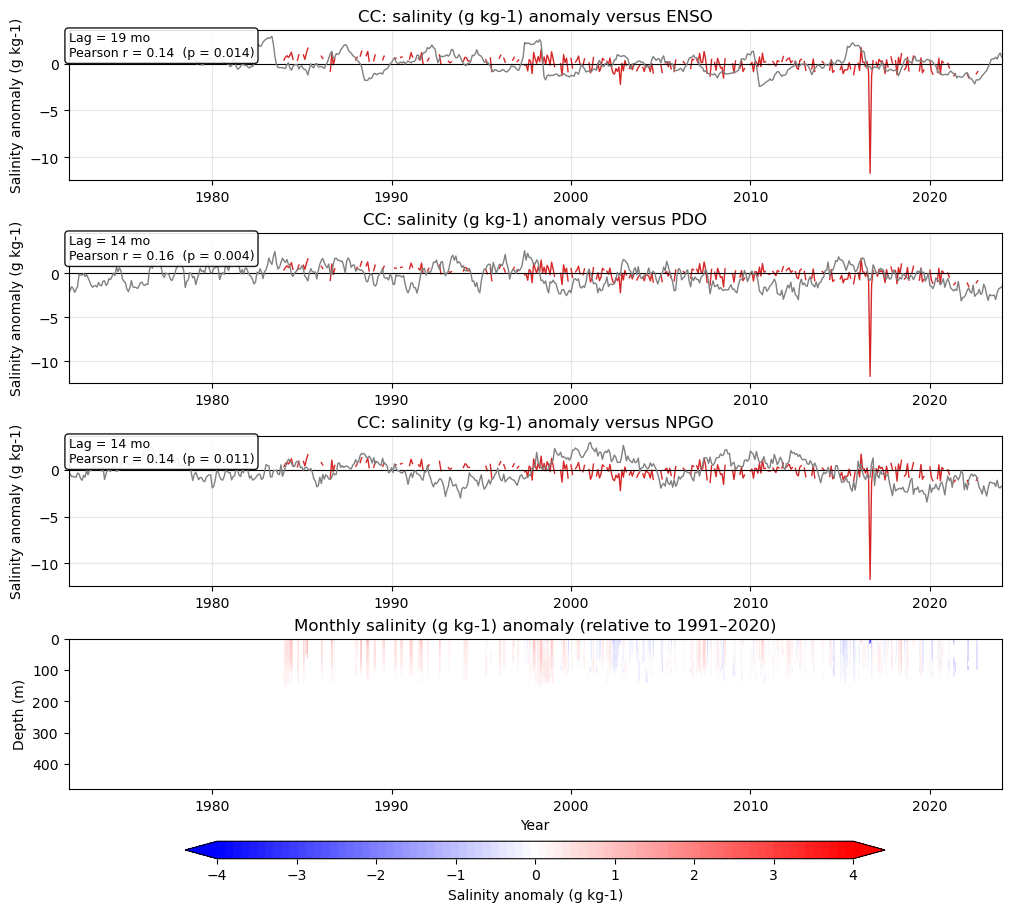

In [14]:
obs_used = obs_cc.copy()
variable_str = 'salinity (g kg-1)'
start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[variable_str])]))
end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[variable_str])]))
max_depth = np.nanmax(obs_used['depth (m)'][~np.isnan(obs_used[variable_str])])
depth_edges = np.arange(0, np.ceil(max_depth / 20) * 20 + 20, 20)
base_period = (1991, 2020)

anom_array, t_month = contour_prep_depth_monthly(
    obs_used, start_yr, end_yr, depth_edges,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

# ---------- plot ----------
fig, ax = plt.subplots(4, 1, figsize=(10, 9), constrained_layout=True)

# --- top 3 pannels: mean anomaly over all depths compared to ENSO, PDO, NPGO---
mean_anom = np.nanmean(anom_array, axis=0) # taking the mean of the depth binned anomaly (reduces depth sampling bias where possible)
indices_name = ['ENSO','PDO','NPGO']
for i in range(3):
    ax[i].plot(t_month, zscore(mean_anom, nan_policy='omit'), color='tab:red', lw=1, label='Mean anomaly') # zscore converts the anom to a -1-1 variation based on std above and below mean
    ax[i].axhline(0, color='k', lw=0.8)
    ax[i].grid(True, alpha=0.3)
    ax[i].set_xlim(start_yr, end_yr + 1)
    ax[i].set_ylabel('Salinity anomaly (g kg-1)')
    ax[i].set_title(f"CC: {variable_str} anomaly versus {indices_name[i]}")

    if i ==0:
        Yind = enso['index']
        Xind = enso['decimal_yr']
        plot_panel(ax[i], mean_anom, enso,t_month)
    elif i ==1:
        Yind = pdo['index']
        Xind = pdo['decimal_yr']
        plot_panel(ax[i], mean_anom, pdo,t_month)
    elif i==2:
        Yind = npgo['index']
        Xind = npgo['decimal_yr']
        plot_panel(ax[i], mean_anom, npgo,t_month)
    ax[i].plot(Xind, Yind, color='gray', lw=1, label=indices_name[i])
# ax[0].legend()

# --- bottom panel: depth–time contour ---
X, Y = np.meshgrid(t_month, depth_edges[:-1])
vmax = 4
levels = np.linspace(-vmax, vmax, 80)
cp = ax[3].contourf(X, Y, anom_array, levels=levels, cmap='bwr', extend='both')
ax[3].invert_yaxis()
# ax[3].set_ylim(250, 0)
ax[3].set_xlim(start_yr, end_yr + 1)
ax[3].set_xlabel('Year')
ax[3].set_ylabel('Depth (m)')
ax[3].set_title(f"Monthly {variable_str} anomaly (relative to {base_period[0]}–{base_period[1]})")

cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.01,
                    aspect=40, shrink=0.75, ticks=np.arange(-vmax, vmax+1))
cbar.set_label('Salinity anomaly (g kg-1)')


## Oxygen Anomaly Plots

/tmp/ipykernel_647005/1175669202.py:18: RuntimeWarning: Mean of empty slice
  mean_anom = np.nanmean(anom_array, axis=0) # taking the mean of the depth binned anomaly (reduces depth sampling bias where possible)


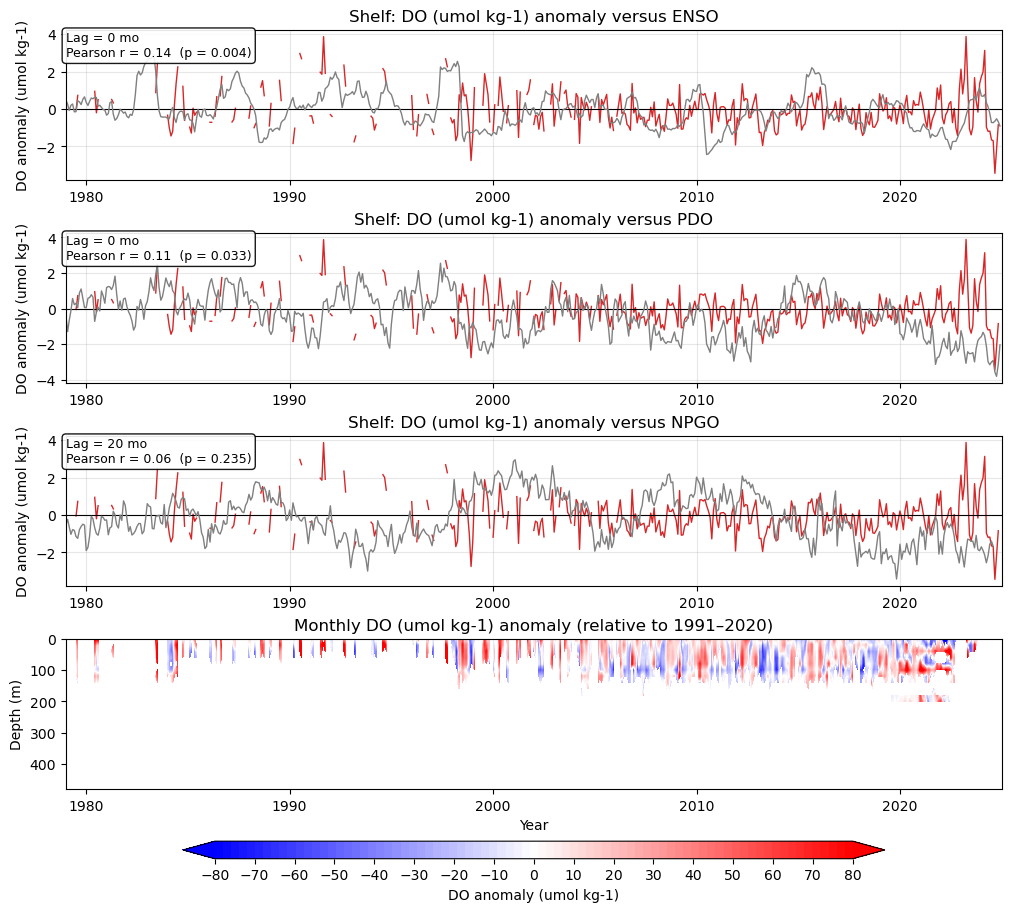

In [15]:
obs_used = obs_shelf.copy()
variable_str = 'DO (umol kg-1)' 
start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[variable_str])]))
end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[variable_str])]))
max_depth = np.nanmax(obs_used['depth (m)'][~np.isnan(obs_used[variable_str])])
depth_edges = np.arange(0, np.ceil(max_depth / 20) * 20 + 20, 20)
base_period = (1991, 2020)

anom_array, t_month = contour_prep_depth_monthly(
    obs_used, start_yr, end_yr, depth_edges,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

# ---------- plot ----------
fig, ax = plt.subplots(4, 1, figsize=(10, 9), constrained_layout=True)

# --- top 3 pannels: mean anomaly over all depths compared to ENSO, PDO, NPGO---
mean_anom = np.nanmean(anom_array, axis=0) # taking the mean of the depth binned anomaly (reduces depth sampling bias where possible)
indices_name = ['ENSO','PDO','NPGO']
for i in range(3):
    ax[i].plot(t_month, zscore(mean_anom, nan_policy='omit'), color='tab:red', lw=1, label='Mean anomaly') # zscore converts the anom to a -1-1 variation based on std above and below mean
    ax[i].axhline(0, color='k', lw=0.8)
    ax[i].grid(True, alpha=0.3)
    ax[i].set_xlim(start_yr, end_yr + 1)
    ax[i].set_ylabel('DO anomaly (umol kg-1)')
    ax[i].set_title(f"Shelf: {variable_str} anomaly versus {indices_name[i]}")

    if i ==0:
        Yind = enso['index']
        Xind = enso['decimal_yr']
        plot_panel(ax[i], mean_anom, enso,t_month)
    elif i ==1:
        Yind = pdo['index']
        Xind = pdo['decimal_yr']
        plot_panel(ax[i], mean_anom, pdo,t_month)
    elif i==2:
        Yind = npgo['index']
        Xind = npgo['decimal_yr']
        plot_panel(ax[i], mean_anom, npgo,t_month)
    ax[i].plot(Xind, Yind, color='gray', lw=1, label=indices_name[i])
# ax[0].legend()

# --- bottom panel: depth–time contour ---
X, Y = np.meshgrid(t_month, depth_edges[:-1])
vmax = 80
levels = np.linspace(-vmax, vmax, 80)
cp = ax[3].contourf(X, Y, anom_array, levels=levels, cmap='bwr', extend='both')
ax[3].invert_yaxis()
# ax[3].set_ylim(250, 0)
ax[3].set_xlim(start_yr, end_yr + 1)
ax[3].set_xlabel('Year')
ax[3].set_ylabel('Depth (m)')
ax[3].set_title(f"Monthly {variable_str} anomaly (relative to {base_period[0]}–{base_period[1]})")

cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.01,
                    aspect=40, shrink=0.75, ticks=np.arange(-vmax, vmax+1,10))
cbar.set_label('DO anomaly (umol kg-1)')


/tmp/ipykernel_647005/3625722895.py:18: RuntimeWarning: Mean of empty slice
  mean_anom = np.nanmean(anom_array, axis=0) # taking the mean of the depth binned anomaly (reduces depth sampling bias where possible)


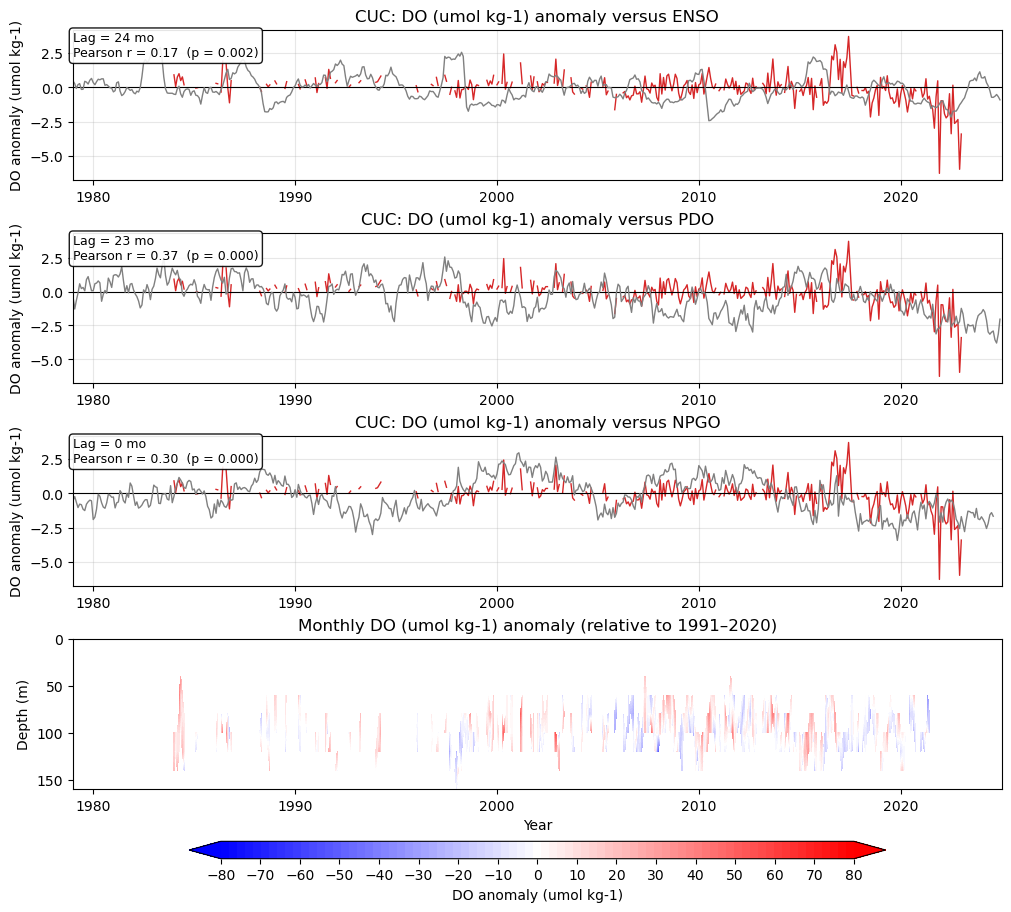

In [16]:
obs_used = obs_cuc.copy()
variable_str = 'DO (umol kg-1)' 
start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[variable_str])]))
end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[variable_str])]))
max_depth = np.nanmax(obs_used['depth (m)'][~np.isnan(obs_used[variable_str])])
depth_edges = np.arange(0, np.ceil(max_depth / 20) * 20 + 20, 20)
base_period = (1991, 2020)

anom_array, t_month = contour_prep_depth_monthly(
    obs_used, start_yr, end_yr, depth_edges,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

# ---------- plot ----------
fig, ax = plt.subplots(4, 1, figsize=(10, 9), constrained_layout=True)

# --- top 3 pannels: mean anomaly over all depths compared to ENSO, PDO, NPGO---
mean_anom = np.nanmean(anom_array, axis=0) # taking the mean of the depth binned anomaly (reduces depth sampling bias where possible)
indices_name = ['ENSO','PDO','NPGO']
for i in range(3):
    ax[i].plot(t_month, zscore(mean_anom, nan_policy='omit'), color='tab:red', lw=1, label='Mean anomaly') # zscore converts the anom to a -1-1 variation based on std above and below mean
    ax[i].axhline(0, color='k', lw=0.8)
    ax[i].grid(True, alpha=0.3)
    ax[i].set_xlim(start_yr, end_yr + 1)
    ax[i].set_ylabel('DO anomaly (umol kg-1)')
    ax[i].set_title(f"CUC: {variable_str} anomaly versus {indices_name[i]}")

    if i ==0:
        Yind = enso['index']
        Xind = enso['decimal_yr']
        plot_panel(ax[i], mean_anom, enso,t_month)
    elif i ==1:
        Yind = pdo['index']
        Xind = pdo['decimal_yr']
        plot_panel(ax[i], mean_anom, pdo,t_month)
    elif i==2:
        Yind = npgo['index']
        Xind = npgo['decimal_yr']
        plot_panel(ax[i], mean_anom, npgo,t_month)
    ax[i].plot(Xind, Yind, color='gray', lw=1, label=indices_name[i])
# ax[0].legend()

# --- bottom panel: depth–time contour ---
X, Y = np.meshgrid(t_month, depth_edges[:-1])
vmax = 80
levels = np.linspace(-vmax, vmax, 80)
cp = ax[3].contourf(X, Y, anom_array, levels=levels, cmap='bwr', extend='both')
ax[3].invert_yaxis()
# ax[3].set_ylim(250, 0)
ax[3].set_xlim(start_yr, end_yr + 1)
ax[3].set_xlabel('Year')
ax[3].set_ylabel('Depth (m)')
ax[3].set_title(f"Monthly {variable_str} anomaly (relative to {base_period[0]}–{base_period[1]})")

cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.01,
                    aspect=40, shrink=0.75, ticks=np.arange(-vmax, vmax+1,10))
cbar.set_label('DO anomaly (umol kg-1)')


/tmp/ipykernel_647005/1032952752.py:18: RuntimeWarning: Mean of empty slice
  mean_anom = np.nanmean(anom_array, axis=0) # taking the mean of the depth binned anomaly (reduces depth sampling bias where possible)


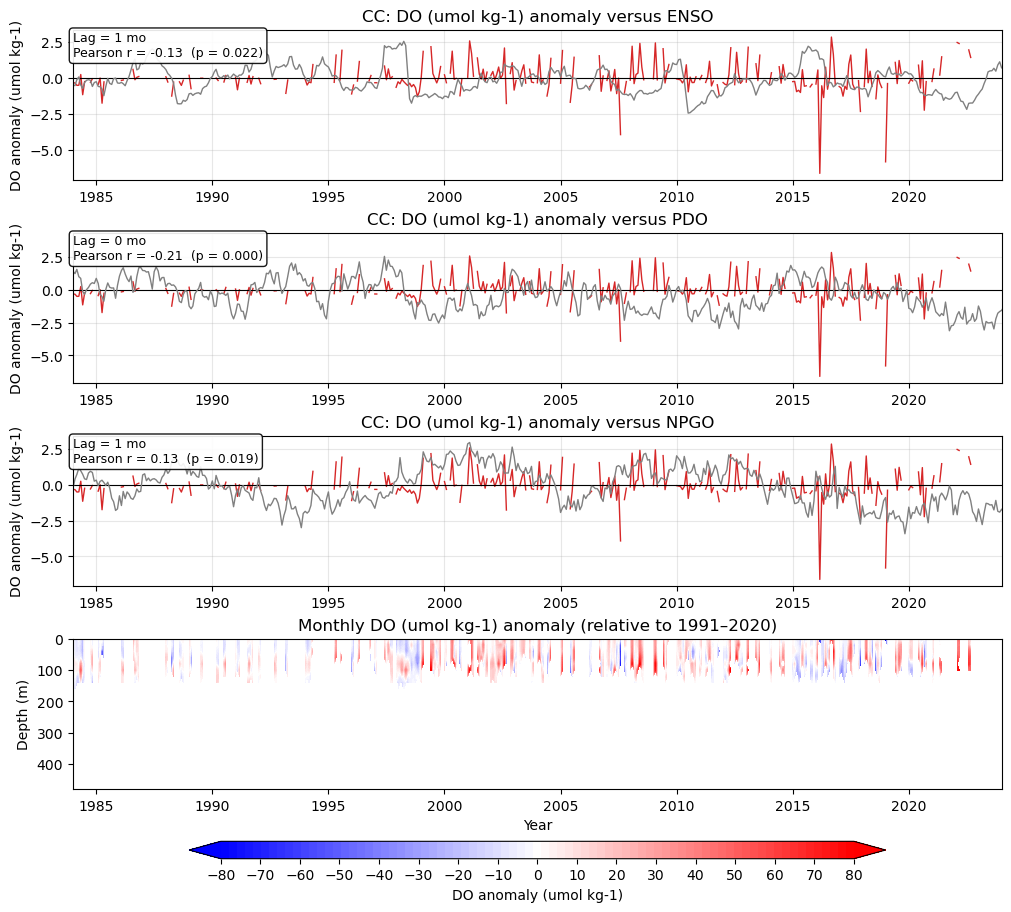

In [17]:
obs_used = obs_cc.copy()
variable_str = 'DO (umol kg-1)' 
start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[variable_str])]))
end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[variable_str])]))
max_depth = np.nanmax(obs_used['depth (m)'][~np.isnan(obs_used[variable_str])])
depth_edges = np.arange(0, np.ceil(max_depth / 20) * 20 + 20, 20)
base_period = (1991, 2020)

anom_array, t_month = contour_prep_depth_monthly(
    obs_used, start_yr, end_yr, depth_edges,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

# ---------- plot ----------
fig, ax = plt.subplots(4, 1, figsize=(10, 9), constrained_layout=True)

# --- top 3 pannels: mean anomaly over all depths compared to ENSO, PDO, NPGO---
mean_anom = np.nanmean(anom_array, axis=0) # taking the mean of the depth binned anomaly (reduces depth sampling bias where possible)
indices_name = ['ENSO','PDO','NPGO']
for i in range(3):
    ax[i].plot(t_month, zscore(mean_anom, nan_policy='omit'), color='tab:red', lw=1, label='Mean anomaly') # zscore converts the anom to a -1-1 variation based on std above and below mean
    ax[i].axhline(0, color='k', lw=0.8)
    ax[i].grid(True, alpha=0.3)
    ax[i].set_xlim(start_yr, end_yr + 1)
    ax[i].set_ylabel('DO anomaly (umol kg-1)')
    ax[i].set_title(f"CC: {variable_str} anomaly versus {indices_name[i]}")

    if i ==0:
        Yind = enso['index']
        Xind = enso['decimal_yr']
        plot_panel(ax[i], mean_anom, enso,t_month)
    elif i ==1:
        Yind = pdo['index']
        Xind = pdo['decimal_yr']
        plot_panel(ax[i], mean_anom, pdo,t_month)
    elif i==2:
        Yind = npgo['index']
        Xind = npgo['decimal_yr']
        plot_panel(ax[i], mean_anom, npgo,t_month)
    ax[i].plot(Xind, Yind, color='gray', lw=1, label=indices_name[i])
# ax[0].legend()

# --- bottom panel: depth–time contour ---
X, Y = np.meshgrid(t_month, depth_edges[:-1])
vmax = 80
levels = np.linspace(-vmax, vmax, 80)
cp = ax[3].contourf(X, Y, anom_array, levels=levels, cmap='bwr', extend='both')
ax[3].invert_yaxis()
# ax[3].set_ylim(250, 0)
ax[3].set_xlim(start_yr, end_yr + 1)
ax[3].set_xlabel('Year')
ax[3].set_ylabel('Depth (m)')
ax[3].set_title(f"Monthly {variable_str} anomaly (relative to {base_period[0]}–{base_period[1]})")

cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.01,
                    aspect=40, shrink=0.75, ticks=np.arange(-vmax, vmax+1,10))
cbar.set_label('DO anomaly (umol kg-1)')


## Temperature Latitude Anomaly Plots

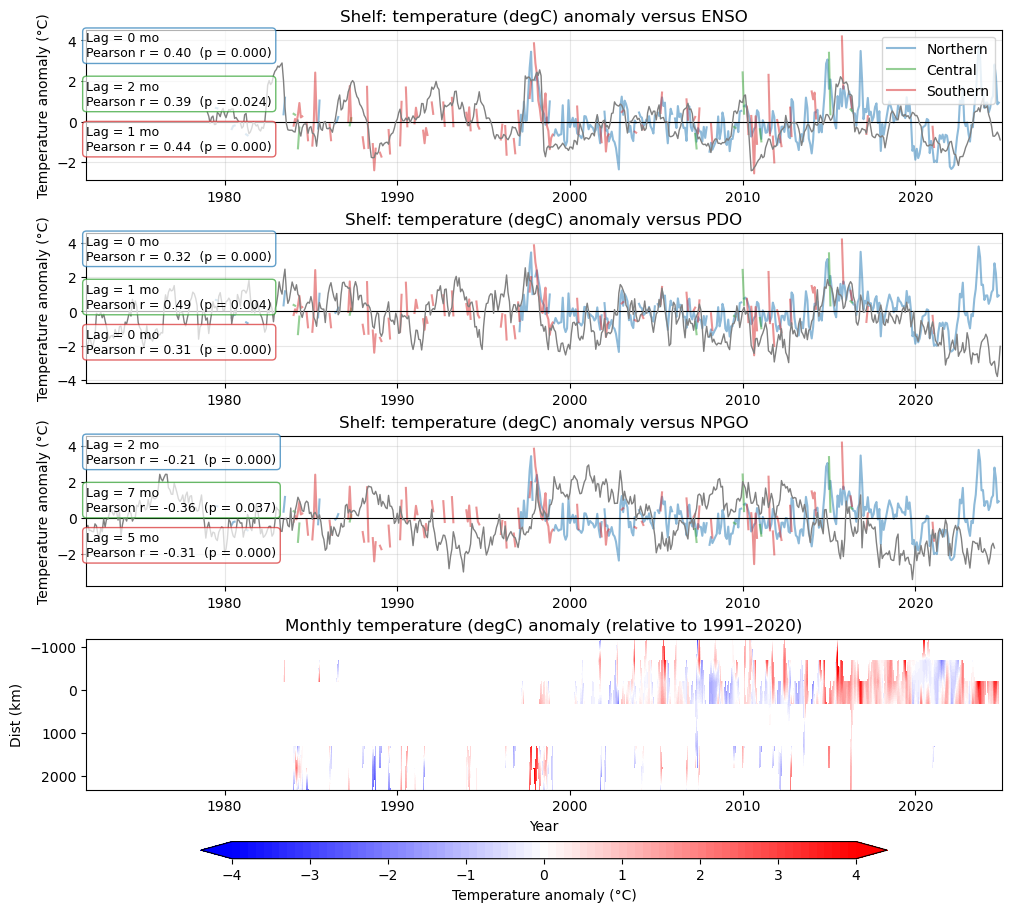

In [ ]:
obs_used = obs_shelf.copy()
variable_str = 'temperature (degC)'
start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[variable_str])]))
end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[variable_str])]))
max_dist = np.nanmax(obs_used['dist'][~np.isnan(obs_used[variable_str])])
min_dist = np.nanmin(obs_used['dist'][~np.isnan(obs_used[variable_str])])
dist_edges1 = [min_dist-1,903,1676,max_dist+1]
dist_edges2 = np.arange(min_dist, max_dist+500, 500)
base_period = (1991, 2020)

anom_array, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges1,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

# ---------- plot ----------
fig, ax = plt.subplots(4, 1, figsize=(10, 9), constrained_layout=True)

# --- top 3 pannels: mean anomaly over all depths compared to ENSO, PDO, NPGO---
# mean_anom = np.nanmean(anom_array, axis=0) # taking the mean of the depth binned anomaly (reduces depth sampling bias where possible)
indices_name = ['ENSO','PDO','NPGO']
for i in range(3):
    ax[i].plot(t_month, zscore(anom_array[0], nan_policy='omit'), color='tab:blue', lw=1.5,alpha=0.5, label='Northern') # zscore converts the anom to a -1-1 variation based on std above and below mean
    ax[i].plot(t_month, zscore(anom_array[1], nan_policy='omit'), color='tab:green', lw=1.5,alpha=0.5, label='Central')
    ax[i].plot(t_month, zscore(anom_array[2], nan_policy='omit'), color='tab:red', lw=1.5,alpha=0.5, label='Southern')
    ax[i].axhline(0, color='k', lw=0.8)
    ax[i].grid(True, alpha=0.3)
    ax[i].set_xlim(start_yr, end_yr + 1)
    ax[i].set_ylabel('Temperature anomaly (°C)')
    ax[i].set_title(f"Shelf: {variable_str} anomaly versus {indices_name[i]}")

    if i ==0:
        Yind = enso['index']
        Xind = enso['decimal_yr']
        plot_panel(ax[i], anom_array[0], enso,t_month,max_lag_months=24,colour='tab:blue')
        plot_panel(ax[i], anom_array[1], enso,t_month,max_lag_months=24,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], anom_array[2], enso,t_month,max_lag_months=24,colour='tab:red',xloc=0,yloc=0.2)

    elif i ==1:
        Yind = pdo['index']
        Xind = pdo['decimal_yr']
        plot_panel(ax[i], anom_array[0], pdo,t_month,max_lag_months=24,colour='tab:blue')
        plot_panel(ax[i], anom_array[1], pdo,t_month,max_lag_months=24,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], anom_array[2], pdo,t_month,max_lag_months=24,colour='tab:red',xloc=0,yloc=0.2)

    elif i==2:
        Yind = npgo['index']
        Xind = npgo['decimal_yr']
        plot_panel(ax[i], anom_array[0], npgo,t_month,max_lag_months=24,colour='tab:blue')
        plot_panel(ax[i], anom_array[1], npgo,t_month,max_lag_months=24,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], anom_array[2], npgo,t_month,max_lag_months=24,colour='tab:red',xloc=0,yloc=0.2)

    ax[i].plot(Xind, Yind, color='gray', lw=1)
ax[0].legend(loc = 'upper right')

# --- bottom panel: depth–time contour ---
anom_array, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges2,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

X, Y = np.meshgrid(t_month, dist_edges2[:-1])
vmax = 4
levels = np.linspace(-vmax, vmax, 80)
cp = ax[3].contourf(X, Y, anom_array, levels=levels, cmap='bwr', extend='both')
ax[3].invert_yaxis()
# ax[3].set_ylim(250, 0)
ax[3].set_xlim(start_yr, end_yr + 1)
ax[3].set_xlabel('Year')
ax[3].set_ylabel('Dist (km)')
ax[3].set_title(f"Monthly {variable_str} anomaly (relative to {base_period[0]}–{base_period[1]})")

cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.01,
                    aspect=40, shrink=0.75, ticks=np.arange(-vmax, vmax+1))
cbar.set_label('Temperature anomaly (°C)')


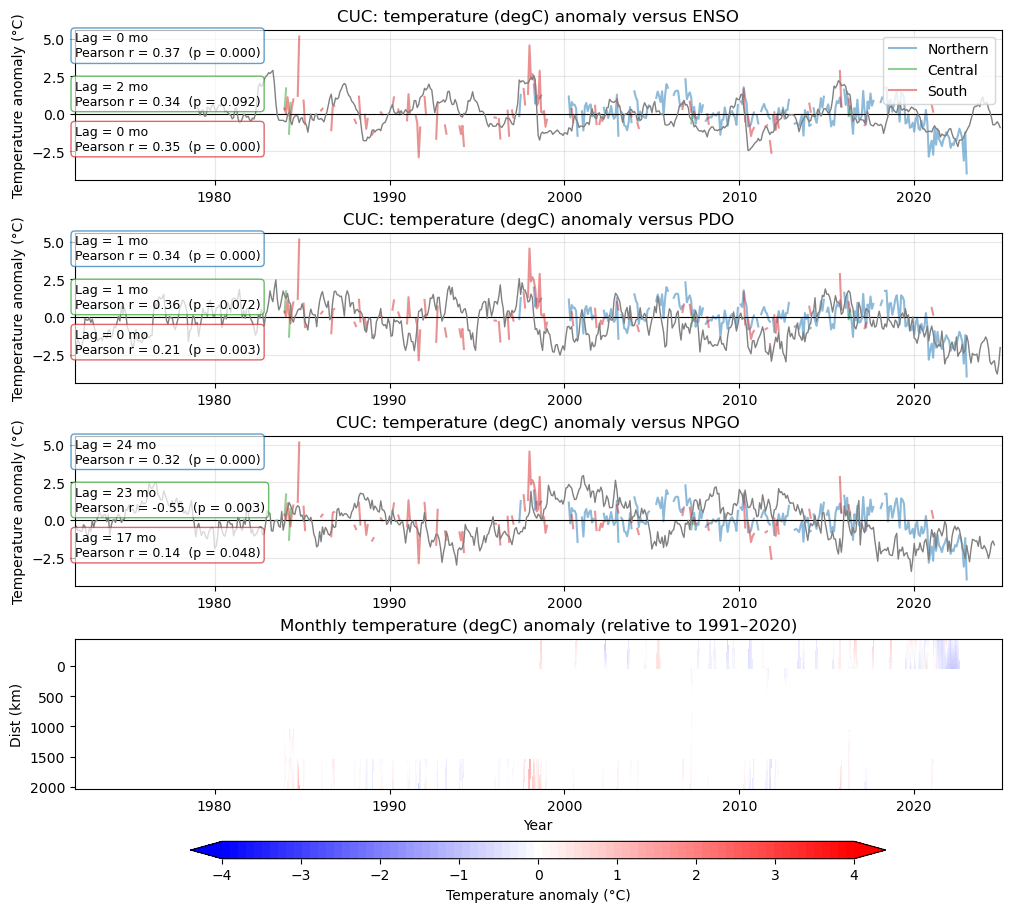

In [28]:
obs_used = obs_cuc.copy()
variable_str = 'temperature (degC)'
start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[variable_str])]))
end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[variable_str])]))
max_dist = np.nanmax(obs_used['dist'][~np.isnan(obs_used[variable_str])])
min_dist = np.nanmin(obs_used['dist'][~np.isnan(obs_used[variable_str])])
dist_edges1 = [min_dist-1,903,1676,max_dist+1]
dist_edges2 = np.arange(min_dist, max_dist+500, 500)
base_period = (1991, 2020)

anom_array, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges1,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

# ---------- plot ----------
fig, ax = plt.subplots(4, 1, figsize=(10, 9), constrained_layout=True)

# --- top 3 pannels: mean anomaly over all depths compared to ENSO, PDO, NPGO---
# mean_anom = np.nanmean(anom_array, axis=0) # taking the mean of the depth binned anomaly (reduces depth sampling bias where possible)
indices_name = ['ENSO','PDO','NPGO']
for i in range(3):
    ax[i].plot(t_month, zscore(anom_array[0], nan_policy='omit'), color='tab:blue', lw=1.5,alpha=0.5, label='Northern') # zscore converts the anom to a -1-1 variation based on std above and below mean
    ax[i].plot(t_month, zscore(anom_array[1], nan_policy='omit'), color='tab:green', lw=1.5,alpha=0.5, label='Central')
    ax[i].plot(t_month, zscore(anom_array[2], nan_policy='omit'), color='tab:red', lw=1.5,alpha=0.5, label='South')
    ax[i].axhline(0, color='k', lw=0.8)
    ax[i].grid(True, alpha=0.3)
    ax[i].set_xlim(start_yr, end_yr + 1)
    ax[i].set_ylabel('Temperature anomaly (°C)')
    ax[i].set_title(f"CUC: {variable_str} anomaly versus {indices_name[i]}")

    if i ==0:
        Yind = enso['index']
        Xind = enso['decimal_yr']
        plot_panel(ax[i], anom_array[0], enso,t_month,max_lag_months=24,colour='tab:blue')
        plot_panel(ax[i], anom_array[1], enso,t_month,max_lag_months=24,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], anom_array[2], enso,t_month,max_lag_months=24,colour='tab:red',xloc=0,yloc=0.2)

    elif i ==1:
        Yind = pdo['index']
        Xind = pdo['decimal_yr']
        plot_panel(ax[i], anom_array[0], pdo,t_month,max_lag_months=24,colour='tab:blue')
        plot_panel(ax[i], anom_array[1], pdo,t_month,max_lag_months=24,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], anom_array[2], pdo,t_month,max_lag_months=24,colour='tab:red',xloc=0,yloc=0.2)

    elif i==2:
        Yind = npgo['index']
        Xind = npgo['decimal_yr']
        plot_panel(ax[i], anom_array[0], npgo,t_month,max_lag_months=24,colour='tab:blue')
        plot_panel(ax[i], anom_array[1], npgo,t_month,max_lag_months=24,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], anom_array[2], npgo,t_month,max_lag_months=24,colour='tab:red',xloc=0,yloc=0.2)

    ax[i].plot(Xind, Yind, color='gray', lw=1)
ax[0].legend(loc = 'upper right')

# --- bottom panel: depth–time contour ---
anom_array, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges2,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

X, Y = np.meshgrid(t_month, dist_edges2[:-1])
vmax = 4
levels = np.linspace(-vmax, vmax, 80)
cp = ax[3].contourf(X, Y, anom_array, levels=levels, cmap='bwr', extend='both')
ax[3].invert_yaxis()
# ax[3].set_ylim(250, 0)
ax[3].set_xlim(start_yr, end_yr + 1)
ax[3].set_xlabel('Year')
ax[3].set_ylabel('Dist (km)')
ax[3].set_title(f"Monthly {variable_str} anomaly (relative to {base_period[0]}–{base_period[1]})")

cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.01,
                    aspect=40, shrink=0.75, ticks=np.arange(-vmax, vmax+1))
cbar.set_label('Temperature anomaly (°C)')


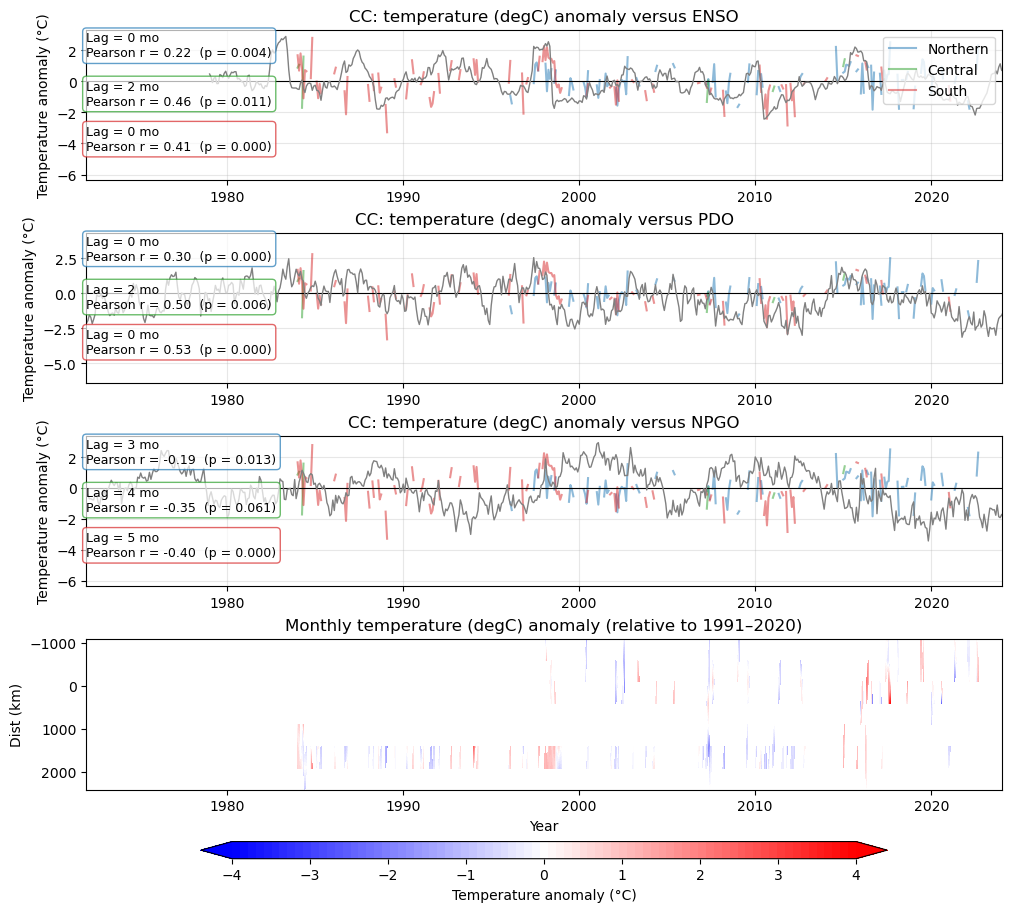

In [29]:
obs_used = obs_cc.copy()
variable_str = 'temperature (degC)'
start_yr = int(np.nanmin(obs_used.year[~np.isnan(obs_used[variable_str])]))
end_yr   = int(np.nanmax(obs_used.year[~np.isnan(obs_used[variable_str])]))
max_dist = np.nanmax(obs_used['dist'][~np.isnan(obs_used[variable_str])])
min_dist = np.nanmin(obs_used['dist'][~np.isnan(obs_used[variable_str])])
dist_edges1 = [min_dist-1,903,1676,max_dist+1]
dist_edges2 = np.arange(min_dist, max_dist+500, 500)
base_period = (1991, 2020)

anom_array, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges1,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

# ---------- plot ----------
fig, ax = plt.subplots(4, 1, figsize=(10, 9), constrained_layout=True)

# --- top 3 pannels: mean anomaly over all depths compared to ENSO, PDO, NPGO---
# mean_anom = np.nanmean(anom_array, axis=0) # taking the mean of the depth binned anomaly (reduces depth sampling bias where possible)
indices_name = ['ENSO','PDO','NPGO']
for i in range(3):
    ax[i].plot(t_month, zscore(anom_array[0], nan_policy='omit'), color='tab:blue', lw=1.5,alpha=0.5, label='Northern') # zscore converts the anom to a -1-1 variation based on std above and below mean
    ax[i].plot(t_month, zscore(anom_array[1], nan_policy='omit'), color='tab:green', lw=1.5,alpha=0.5, label='Central')
    ax[i].plot(t_month, zscore(anom_array[2], nan_policy='omit'), color='tab:red', lw=1.5,alpha=0.5, label='South')
    ax[i].axhline(0, color='k', lw=0.8)
    ax[i].grid(True, alpha=0.3)
    ax[i].set_xlim(start_yr, end_yr + 1)
    ax[i].set_ylabel('Temperature anomaly (°C)')
    ax[i].set_title(f"CC: {variable_str} anomaly versus {indices_name[i]}")

    if i ==0:
        Yind = enso['index']
        Xind = enso['decimal_yr']
        plot_panel(ax[i], anom_array[0], enso,t_month,max_lag_months=24,colour='tab:blue')
        plot_panel(ax[i], anom_array[1], enso,t_month,max_lag_months=24,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], anom_array[2], enso,t_month,max_lag_months=24,colour='tab:red',xloc=0,yloc=0.2)

    elif i ==1:
        Yind = pdo['index']
        Xind = pdo['decimal_yr']
        plot_panel(ax[i], anom_array[0], pdo,t_month,max_lag_months=24,colour='tab:blue')
        plot_panel(ax[i], anom_array[1], pdo,t_month,max_lag_months=24,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], anom_array[2], pdo,t_month,max_lag_months=24,colour='tab:red',xloc=0,yloc=0.2)

    elif i==2:
        Yind = npgo['index']
        Xind = npgo['decimal_yr']
        plot_panel(ax[i], anom_array[0], npgo,t_month,max_lag_months=24,colour='tab:blue')
        plot_panel(ax[i], anom_array[1], npgo,t_month,max_lag_months=24,colour='tab:green',xloc=0,yloc=0.5)
        plot_panel(ax[i], anom_array[2], npgo,t_month,max_lag_months=24,colour='tab:red',xloc=0,yloc=0.2)

    ax[i].plot(Xind, Yind, color='gray', lw=1)
ax[0].legend(loc = 'upper right')

# --- bottom panel: depth–time contour ---
anom_array, t_month = contour_prep_dist_monthly(
    obs_used, start_yr, end_yr, dist_edges2,
    variable_str, base_period=base_period, min_samples_per_cell=3
)

X, Y = np.meshgrid(t_month, dist_edges2[:-1])
vmax = 4
levels = np.linspace(-vmax, vmax, 80)
cp = ax[3].contourf(X, Y, anom_array, levels=levels, cmap='bwr', extend='both')
ax[3].invert_yaxis()
# ax[3].set_ylim(250, 0)
ax[3].set_xlim(start_yr, end_yr + 1)
ax[3].set_xlabel('Year')
ax[3].set_ylabel('Dist (km)')
ax[3].set_title(f"Monthly {variable_str} anomaly (relative to {base_period[0]}–{base_period[1]})")

cbar = fig.colorbar(cp, ax=ax, orientation='horizontal', pad=0.01,
                    aspect=40, shrink=0.75, ticks=np.arange(-vmax, vmax+1))
cbar.set_label('Temperature anomaly (°C)')
